# Sistem Rekomendasi Anime dengan Metode Collaborative Filtering

**Oleh Abdul Ghofur Rais Kumar**

***Project Submission Machine Learning Terapan***

## Project Overview

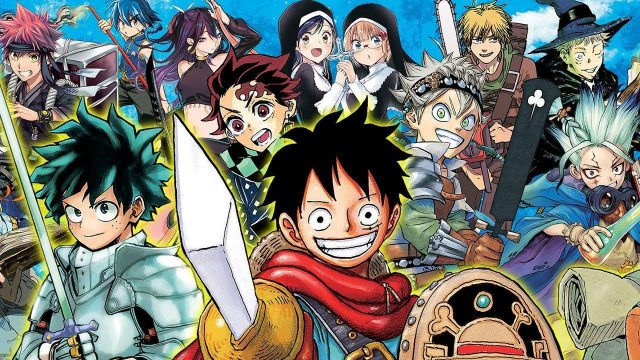

Anime adalah animasi dari Jepang yang digambar dengan tangan maupun menggunakan teknologi komputer. Kata anime merupakan singkatan dari "animation" dalam Bahasa Inggris, yang merujuk pada semua jenis animasi.Di luar Jepang, istilah ini digunakan secara spesifik untuk menyebutkan segala animasi yang diproduksi di Jepang. Meskipun demikian, tidak menutup kemungkinan bahwa anime dapat diproduksi di luar Jepang.Beberapa ahli berpendapat bahwa anime merupakan bentuk baru dari orientalisme.

Saat ini, ada banyak sekali platform yang memudahkan kita untuk menonton serial anime. Mulai dari layanan tv rumahan, k=hingga layanan streaming anime online. Hal ini sangat membantu kita untuk dapat mengakses anime. Sehingga kepopuleran anime semakin meningkat seiring dengan perkembangan Tv dan Internet.

Semakin berkembangnya anime sebagai sarana hiburan menimbulkan semakin banyaknya perusahaan animasi yang terjun didalamnya untuk ikut memproduksi anime. Sehingga semakin banyak anime yang beredar di pasaran. Dengan membanjirnya jumlah anime yang diproduksi, konsumen juga akan semakin banyak opsi untuk menonton jenis anime yang mereka sukai. 

Namun, dengan semakin banyaknya anime yang ada, menyulitkan konsumen untuk dapat menemukan anime yang sesuai dengan keinginan mereka jika harus memilih dari tumpukan judul anime yang tersedia. Sehingga dibutuhkan suatu sistem yang dapat menyarankan pengguna dalam memilih anime yang sesuai dengan keinginan mereka.

Pada kali ini, kita akan membuat suatu sistem rekomendasi dengan metode Collaborative Filtering untuk memudahkan pengguna dalam memilih anime yang mereka suka.

### Tentang Dataset

Dataset ini ini berisi informasi tentang data preferensi pengguna dari 73.516 pengguna di 12.294 anime. Dimana setiap pengguna dapat menambahkan anime ke dalam daftar dan memberikan peringkat dan kumpulan data ini adalah kompilasi dari peringkat tersebut.

Sumber dataset : [Anime Recommendations Database](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

### Isi dataset

Anime.csv
- anime_id : id unik myanimelist.net dari setiap anime.
- name : nama lengkap anime.
- genre : daftar genre anime yang dipisahkan koma.
- type : Jenis anime(film, TV, OVA, dll).
- episode : berapa banyak episode dalam acara ini. (1 jika film).
- rating : rating rata-rata dari 10 untuk anime ini.
- members : jumlah anggota komunitas yang ada di anime ini.

Rating.csv

- user_id : ID pengguna yang dibuat secara acak yang tidak dapat diidentifikasi.
- anime_id : anime yang telah dinilai oleh pengguna ini.
- rating : rating dari 10 yang telah ditetapkan pengguna ini (-1 jika pengguna menontonnya tetapi tidak memberikan rating).

### Import Library

Langkah pertama yang dapat kita lakukan adalah melakukan import library yang dibutuhkan. 

In [1]:
#Import Library yang dibutuhkan
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline

### Membaca Dataset

Selanjutnya adalah membaca dataset yang digunakan

In [2]:
#Melakukan Mounting google drive untuk mengakses google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Membaca dataset dan memuat data pada dataframe di variabel anime dan rating
anime = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/anime.csv')
rating = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/rating.csv')

In [4]:
# melihat informasi dari dataset dengan menggunakan fungsi .shape dan .info
print ("Ukuran dari dataset anime(baris, kolom): "+ str(anime.shape))
print (anime.info())

Ukuran dari dataset anime(baris, kolom): (12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None


In [5]:
#Melihat 5 data teratas pada dataset anime
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
print ("Ukuran dari dataset rating(baris, kolom): "+ str(rating.shape))
print (rating.info())

Ukuran dari dataset rating(baris, kolom): (7813737, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


In [7]:
#Melihat lima data teratas pada dataset rating
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


### Preprocssing

Pada dataset, nilai missing value dari rating, diisi dengan nilai -1.  Kita akan mengubah setiap rating yang bernilai -1, denan nilai null value, dikarenakan selanjutkan kita akan menghitung rata-rata rating tiap user. Sehingga diharapkan rating tidak terdistrosi.

In [8]:
#Mengubah nilai -1 kolom rating menjadi NaN
rating['rating'].replace(-1, np.nan, regex=True, inplace = True)
rating.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


In [9]:
#Melihat proporsi tipe platform streaming
import plotly.graph_objects as go
labels = anime['type'].value_counts().index
values = anime['type'].value_counts().values
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Media Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Pada analisis ini, kita hanya akan menggunakan anime yang tayang di tv, dimana tv adalah media dengan jumlah anime terbanyak. 

In [10]:
#Mengambil daftar anime yang tayang di media TV

anime_tv = anime[anime['type']=='TV']
anime_tv.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


In [11]:
# Menggabungkan dataframe anime_tv dan dataframe rating kedalam satu dataframe

merged = rating.merge(anime_tv, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
merged.rename(columns = {'rating_user':'user_rating'}, inplace = True)
merged.head()

,user_id,anime_id,user_rating,name,genre,type,episodes,rating,members
0,1,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


Dikarenakan jumlah data kita yang sangat besar, sehingga akan memerlukan memori yang besar. Untuk mengatasi masalah komputasi tersebut, kita hanya akan melakukan limitasi dataframe sebesar 20.000 user.

In [12]:
# membatasi jumlah user_id dalam dataframe sebesar 20.000

merged_sub=merged[['user_id', 'name', 'user_rating']]
merged_sub= merged[merged.user_id <= 20000]
merged_sub.head()

,user_id,anime_id,user_rating,name,genre,type,episodes,rating,members
0,1,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


Dalam collaborative filtering, kita perlu membuat tabel pivot 'user_id' pada satu sumbu dan 'name' di sumbu lainnya. Tabel pivot akan membantu kami dalam menentukan kesamaan antara pengguna dan anime untuk memprediksi dengan lebih baik siapa yang akan menyukai apa. 

In [13]:
#melakukan pivoting tabel untuk user_id dan name
piv = merged_sub.pivot_table(index=['user_id'], columns=['name'], values='user_rating')
print(piv.shape)


(18723, 2849)


In [14]:
# Normalisasi values dengan menggunakan min-max normalization
piv_norm = piv.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

In [15]:
# drop kolom yang hanya berisi nilai 0 yang mewakili user yang tidak mememberikan rating
piv_norm.fillna(0, inplace=True)
piv_norm = piv_norm.T
piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

In [16]:
# Mengubah data kita menjadi spare matrix(matrix berongga) untuk dapat melanjutkan ke tahap selanjutnya
piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

### Modeling

Pada modeling, kita akan menggunakan metode cosine similiarity untuk mendapatkan rekomendasi anime. Kita dapat melakukan metode cosine similiarity dengan cara memanggil fungsi cosine_similarity dengan argumen dataframe sebagai objeknya pada library sklearn.  

In [17]:
# Kita akan mencari nilai Cosine_similarity(kesamaan kosinus) yang dihitung antara setiap pasangan user/user array dan pasangan item/item array
item_similarity = cosine_similarity(piv_sparse)
user_similarity = cosine_similarity(piv_sparse.T)

In [18]:
# memasukkan kesamaan matrix kedalam objek dataframe
item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.index, columns = piv_norm.index)
user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.columns, columns = piv_norm.columns)

In [19]:
# Membuat function untuk mendapatkan 10 anime dengan kesamaan kosinus tertinggi
def top_animes(nama_anime):
    count = 1
    print('Anime yang mirip dengan {} adalah:\n'.format(nama_anime))
    for item in item_sim_df.sort_values(by = nama_anime, ascending = False).index[1:11]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [20]:
# Membuat fungsi untuk mendapatkan 10 user dengan kesamaan kosinus tertinggi
def top_users(user):
    
    if user not in piv_norm.columns:
        return('tidak ada data user {}'.format(user))
    
    print('User yang paling mirip dengan:\n')
    sim_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:11]
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    zipped = zip(sim_users, sim_values,)
    for user, sim in zipped:
        print('User #{0}, Nilai Kesamaan: {1:.2f}'.format(user, sim)) 

In [21]:
# Membuat fungsi untuk mendapatkan daftar yang berisi anime dengan rating tinggi per pengguna yang mirip
# dan mengembalikan nama anime beserta frekuensi kemunculannya dalam daftar
def similar_user_recs(user):
    
    if user not in piv_norm.columns:
        return('Tidak ada data untuk user {}'.format(user))
    
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = piv_norm.loc[:, i].max()
        best.append(piv_norm[piv_norm.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]    

In [22]:
# Fungsi ini menghitung rata-rata tertimbang(weighted average) dari pengguna serupa
# untuk menentukan rating potensial untuk input pengguna dan anime

def predicted_rating(anime_name, user):
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:1000]
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:1000]
    rating_list = []
    weight_list = []
    for j, i in enumerate(sim_users):
        rating = piv.loc[i, anime_name]
        similarity = user_values[j]
        if np.isnan(rating):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    return sum(rating_list)/sum(weight_list)  

### Melakukan Rekomendasi

In [23]:
#mendapatkan 10 anime paling mirip dengan gintama
top_animes('Gintama')

Anime yang mirip dengan Gintama adalah:

No. 1: Gintama&#039;
No. 2: Gintama&#039;: Enchousen
No. 3: Gintama°
No. 4: Fullmetal Alchemist: Brotherhood
No. 5: Hunter x Hunter (2011)
No. 6: Steins;Gate
No. 7: Fate/Zero 2nd Season
No. 8: Code Geass: Hangyaku no Lelouch R2
No. 9: One Punch Man
No. 10: Tengen Toppa Gurren Lagann


In [24]:
#mendapatkan 10 anime paling mirip dengan naruto
top_animes('Naruto')

Anime yang mirip dengan Naruto adalah:

No. 1: Bleach
No. 2: Dragon Ball GT
No. 3: Yu☆Gi☆Oh! Duel Monsters
No. 4: Dragon Ball Z
No. 5: Fairy Tail
No. 6: Pokemon Advanced Generation
No. 7: Ao no Exorcist
No. 8: D.Gray-man
No. 9: Dragon Ball
No. 10: Highschool of the Dead


In [25]:
#mendapatkan 10 user dengan kesukaan paling mirip dengan user 5
top_users(5)

User yang paling mirip dengan:

User #4512, Nilai Kesamaan: 0.28
User #2300, Nilai Kesamaan: 0.27
User #12033, Nilai Kesamaan: 0.27
User #14507, Nilai Kesamaan: 0.25
User #19689, Nilai Kesamaan: 0.25
User #4064, Nilai Kesamaan: 0.25
User #1682, Nilai Kesamaan: 0.25
User #14752, Nilai Kesamaan: 0.25
User #16572, Nilai Kesamaan: 0.24
User #16698, Nilai Kesamaan: 0.24


In [26]:
#Rekomendasi anime untuk user 5, berdasarkan kemiripannya dengan user lain
similar_user_recs(5)

[('Steins;Gate', 7),
 ('Hunter x Hunter (2011)', 6),
 ('Clannad: After Story', 5),
 ('Death Note', 4),
 ('Shigatsu wa Kimi no Uso', 4)]

In [27]:
#rating potensial untuk user no 5 dan anime gintama
predicted_rating('Gintama', 5)

9.352003113118874

### Evaluasi

Di bawah ini kita akan melihat bagaimana kinerja fungsi predict_rating dibandingkan dengan nilai nilai yang diamati untuk pengguna 5. 

In [31]:
# membuat list dengan anime yang telah ditonton oleh user no 5

watched = piv.T[piv.loc[5,:]>0].index.tolist()


In [32]:
# Membuat list squared error antara nilai sebenarnya dengan nilai prediksi
errors = []
for i in watched:
    actual=piv.loc[5, i]
    predicted = predicted_rating(i, 5)
    errors.append((actual-predicted)**2)

In [33]:
# Berikut dalah nilai Mean Squared Error untuk user 5
np.mean(errors)

12.505601634667572

Berdasarkan perhitungan nilai Mean Squared Error diatas, kita mendapatkan nilai MSE sebesar 12.5. Hal ini tergolong rendah(kita memangkatkan nilai error rata-rata) sehingga sistem rekomendasi dapat kita gunakan. Hasil dari nilai rekomendasi yang dilakukan juga cukup baik. Namun, peningkatan performa sistem masih dapat dilakukan kedepannya dengan algoritma yang lebih baik.